## Задание 1

В коде из презентации реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [6]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

In [7]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # Индекс признака
        self.t = t          # Пороговое значение
        self.true_branch = true_branch
        self.false_branch = false_branch

In [8]:
class Leaf:
    def __init__(self, data, labels):
        self.data = data  # Данные в листе
        self.labels = labels  # Метки классов
        self.prediction = self.predict()  # Прогноз

    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        prediction = max(classes, key=classes.get)
        return prediction

In [9]:
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 1  # Начальное значение
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

In [10]:
# Прирост
def gain(left_labels, right_labels, root_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [11]:
# Разделяю данные на две части по пороговому значению и признаку
def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [12]:
def find_best_split(data, labels):
    min_samples_leaf = 3

    root_gini = gini(labels)  # джини для корня (как база для сравнений)

    best_gain = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]  # кортеж - размеры массива (количество признаков)

    for index in range(n_features):
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            current_gain = gain(true_labels, false_labels, root_gini)

            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [13]:
import time

# рекур
def build_tree(data, labels):
    gain, t, index = find_best_split(data, labels)

    if gain == 0:
        return Leaf(data, labels) # всё плохо, не разбиваем

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels) # рекур
    false_branch = build_tree(false_data, false_labels) # рекур

    return Node(index, t, true_branch, false_branch)

In [14]:
import time

def build_tree_force_height(data, labels, max_depth, current_depth=0):
    if current_depth >= max_depth: # непосредственно запрет делить
        return Leaf(data, labels)

    gain, t, index = find_best_split(data, labels)

    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree_force_height(true_data, true_labels, max_depth, current_depth + 1)
    false_branch = build_tree_force_height(false_data, false_labels, max_depth, current_depth + 1)

    return Node(index, t, true_branch, false_branch)


In [15]:
def build_tree_force_leaves(data, labels, max_leaves, leaf_count=0):
    if leaf_count >= max_leaves: # непосредственно запрет делить
        return Leaf(data, labels)

    gain, t, index = find_best_split(data, labels)

    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_leaf_count = leaf_count + 1
    false_leaf_count = leaf_count + 1

    true_branch = build_tree_force_leaves(true_data, true_labels, max_leaves, true_leaf_count)
    false_branch = build_tree_force_leaves(false_data, false_labels, max_leaves, false_leaf_count)

    return Node(index, t, true_branch, false_branch)


In [16]:
def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [17]:
def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [18]:
from sklearn.datasets import make_classification, make_circles

# Плейсхолдер дата

classification_data, classification_labels = make_classification(
    n_features=5, n_informative=5, n_classes=2, n_redundant=0,
    n_clusters_per_class=1, random_state=5
)
classification_data, classification_labels = make_circles(n_samples=30, random_state=5)

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(
    classification_data, classification_labels,test_size=0.3, random_state=1
)

In [19]:
import numpy as np

tree_default = build_tree(train_data, train_labels)
tree_force_height = build_tree_force_height(train_data, train_labels, 7)
tree_force_leaves = build_tree_force_leaves(train_data, train_labels, 3)

In [20]:
def print_tree(node, level=0):
    if isinstance(node, Leaf):
        print(" " * (level * 4) + f"Лист: Прогноз = {node.prediction}")
        return

    print(" " * (level * 4) + f"Уровень {level}: Индекс = {node.index}, Условие <= {node.t}")

    print(" " * (level * 4) + "--> True:")
    print_tree(node.true_branch, level + 1)

    print(" " * (level * 4) + "--> False:")
    print_tree(node.false_branch, level + 1)

In [21]:
print_tree(tree_default)

Уровень 0: Индекс = 1, Условие <= -0.8660254037844384
--> True:
    Лист: Прогноз = 0
--> False:
    Уровень 1: Индекс = 0, Условие <= -0.8090169943749476
    --> True:
        Лист: Прогноз = 0
    --> False:
        Уровень 2: Индекс = 0, Условие <= 0.24721359549995797
        --> True:
            Уровень 3: Индекс = 1, Условие <= 0.7956175162946187
            --> True:
                Лист: Прогноз = 1
            --> False:
                Лист: Прогноз = 0
        --> False:
            Уровень 3: Индекс = 0, Условие <= 0.8
            --> True:
                Уровень 4: Индекс = 0, Условие <= 0.6691306063588582
                --> True:
                    Уровень 5: Индекс = 0, Условие <= 0.5353044850870866
                    --> True:
                        Уровень 6: Индекс = 0, Условие <= 0.30901699437494745
                        --> True:
                            Лист: Прогноз = 0
                        --> False:
                            Лист: Прогноз = 1
    

In [22]:
print_tree(tree_force_height)

Уровень 0: Индекс = 1, Условие <= -0.8660254037844384
--> True:
    Лист: Прогноз = 0
--> False:
    Уровень 1: Индекс = 0, Условие <= -0.8090169943749476
    --> True:
        Лист: Прогноз = 0
    --> False:
        Уровень 2: Индекс = 0, Условие <= 0.24721359549995797
        --> True:
            Уровень 3: Индекс = 1, Условие <= 0.7956175162946187
            --> True:
                Лист: Прогноз = 1
            --> False:
                Лист: Прогноз = 0
        --> False:
            Уровень 3: Индекс = 0, Условие <= 0.8
            --> True:
                Уровень 4: Индекс = 0, Условие <= 0.6691306063588582
                --> True:
                    Уровень 5: Индекс = 0, Условие <= 0.5353044850870866
                    --> True:
                        Уровень 6: Индекс = 0, Условие <= 0.30901699437494745
                        --> True:
                            Лист: Прогноз = 0
                        --> False:
                            Лист: Прогноз = 1
    

In [23]:
print_tree(tree_force_leaves)

Уровень 0: Индекс = 1, Условие <= -0.8660254037844384
--> True:
    Лист: Прогноз = 0
--> False:
    Уровень 1: Индекс = 0, Условие <= -0.8090169943749476
    --> True:
        Лист: Прогноз = 0
    --> False:
        Уровень 2: Индекс = 0, Условие <= 0.24721359549995797
        --> True:
            Лист: Прогноз = 1
        --> False:
            Лист: Прогноз = 0


In [24]:

train_answers_default = predict(train_data, tree_default)
answers_default = predict(test_data, tree_default)

train_answers_force_height = predict(train_data, tree_force_height)
answers_force_height = predict(test_data, tree_force_height)

train_answers_force_leaves = predict(train_data, tree_force_leaves)
answers_force_leaves = predict(test_data, tree_force_leaves)


In [25]:
def percent_true(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [26]:
train_accuracy = percent_true(train_labels, train_answers_default)
train_accuracy

100.0

In [27]:
test_accuracy = percent_true(test_labels, answers_default)
test_accuracy

88.88888888888889

## Задание 2

Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в презентации, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [28]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

In [29]:
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        return np.mean(self.labels)

In [30]:
def build_tree(data, labels):
    best_variance, t, index = find_best_split_variance(data, labels)

    if index is None:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

def find_best_split_variance(data, labels):
    min_samples_leaf = 3

    root_variance = variance(labels)

    best_variance = 1000000000
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            if (not (len(true_labels) < min_samples_leaf or len(false_labels) < min_samples_leaf)):
                current_variance = gain(true_labels, false_labels, root_variance)

                if current_variance < best_variance:
                    best_variance, best_t, best_index = current_variance, t, index

    return (best_variance, best_t, best_index) if best_index is not None else (None, None, None)

def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

def variance(labels):
    if len(labels) == 0:
        return 0
    return np.var(labels)

def gain(left_labels, right_labels, root_variance):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return root_variance - (p * variance(left_labels) + (1 - p) * variance(right_labels))

MSE: 108.35312106719464


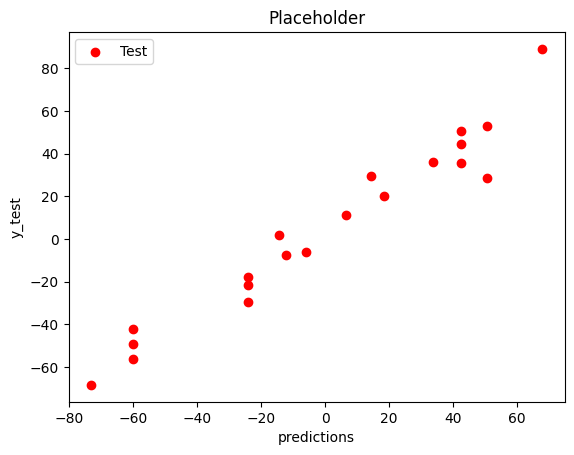

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Плейсхолер дата

X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = build_tree(X_train, y_train)

def predict(tree, X):
    if isinstance(tree, Leaf):
        return tree.prediction
    else:
        if X[tree.index] <= tree.t:
            return predict(tree.true_branch, X)
        else:
            return predict(tree.false_branch, X)

predictions = np.array([predict(tree, x) for x in X_test])

mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')

plt.scatter(predictions, y_test, color='red', label='Test')
plt.legend()
plt.title('Placeholder')
plt.xlabel('predictions')
plt.ylabel('y_test')
plt.show()

In [ ]:
def print_tree(node, level=0):
    if isinstance(node, Leaf):
        print(" " * (level * 4) + f"Лист: Прогноз = {node.prediction}")
        return

    print(" " * (level * 4) + f"Уровень {level}: Индекс = {node.index}, Условие <= {node.t}")

    print(" " * (level * 4) + "--> True:")
    print_tree(node.true_branch, level + 1)

    print(" " * (level * 4) + "--> False:")
    print_tree(node.false_branch, level + 1)

In [ ]:
print_tree(tree)

Уровень 0: Индекс = 0, Условие <= 1.5380365664659692
--> True:
    Уровень 1: Индекс = 0, Условие <= 1.356240028570823
    --> True:
        Уровень 2: Индекс = 0, Условие <= 0.9686449905328892
        --> True:
            Уровень 3: Индекс = 0, Условие <= 0.7674347291529088
            --> True:
                Уровень 4: Индекс = 0, Условие <= 0.5425600435859647
                --> True:
                    Уровень 5: Индекс = 0, Условие <= 0.36163602504763415
                    --> True:
                        Уровень 6: Индекс = 0, Условие <= 0.33126343140356396
                        --> True:
                            Уровень 7: Индекс = 0, Условие <= 0.3142473325952739
                            --> True:
                                Уровень 8: Индекс = 0, Условие <= 0.2088635950047554
                                --> True:
                                    Уровень 9: Индекс = 0, Условие <= 0.11092258970986608
                                    --> True:
        